## Import & Setup
---

In [ ]:
!pip install -U spacy

     |████████████████████████████████| 6.2 MB 14.2 MB/s 
     |████████████████████████████████| 653 kB 21.4 MB/s 
     |████████████████████████████████| 181 kB 58.3 MB/s 
     |████████████████████████████████| 10.1 MB 48.6 MB/s 
     |████████████████████████████████| 42 kB 895 kB/s 
     |████████████████████████████████| 457 kB 43.1 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    

In [ ]:
!python -m spacy download en_core_web_lg
# need to restart this session once it is installed

     |████████████████████████████████| 400.7 MB 6.4 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 4.0 MB 33.7 MB/s 
     |████████████████████████████████| 1.2 MB 61.4 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 880 kB 68.2 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=468e77b52573d58660058e085283f1e79e01bc1b56f8aa1792636b6129221b46
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=9ef86e393849392e040d4cb44a9a8eb879e5d272016cf7b7c95a602b1e03c023
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

## Project Dataset Loading

In [ ]:
import zipfile
import os
import numpy as np
import xml.etree.ElementTree as ET
import glob
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Clone the dataset repository from github
!git clone https://github.com/CodyRichter/Automatic-Short-Answer-Grading

Cloning into 'Automatic-Short-Answer-Grading'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 33 (delta 12), reused 23 (delta 8), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
import json

with open('/content/Automatic-Short-Answer-Grading/dataset/train.json', 'r') as tf:
  training_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-answers.json', 'r') as tf:
  test_unseen_answer_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-questions.json', 'r') as tf:
  test_unseen_question_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-domains.json', 'r') as tf:
  test_unseen_domain_data = json.load(tf)

print('Number of Training Data Responses', len(training_data))
print('Number of Test Data (New Answer) Responses', len(test_unseen_answer_data))
print('Number of Test Data (New Question) Responses', len(test_unseen_question_data))
print('Number of Test Data (New Domain) Responses', len(test_unseen_domain_data))

Number of Training Data Responses 16265
Number of Test Data (New Answer) Responses 540
Number of Test Data (New Question) Responses 733
Number of Test Data (New Domain) Responses 4562


In [ ]:
new_training_data = []
for entry in training_data:
    if not entry['aug']:
      new_training_data.append(entry)

training_data = new_training_data

print('Number of Training Data Responses', len(training_data))

Number of Training Data Responses 4969


## Visualize Data and Size

In [ ]:
#Set up training_data & test_data
test_data = test_unseen_question_data
print(training_data[0])
print(training_data[1])
print(len(training_data))
print(len(test_data))

{'question': 'The sand and flour in the gray material from mock rocks is separated by mixing with water and allowing the mixture to settle. Explain why the sand and flour separate.', 'ref': 'The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.', 'response': 'One is heavier than another see it settles in how many layers there is ingredients.', 'score': 'correct', 'aug': False, 'id': 0}
{'question': 'The sand and flour in the gray material from mock rocks is separated by mixing with water and allowing the mixture to settle. Explain why the sand and flour separate.', 'ref': 'The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.', 'response': 'Because the sand is heavier.', 'score': 'correct', 'aug': False, 'id': 1}
4969
733


## Installation sentence-transformers
---

In [ ]:
from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('all-MiniLM-L6-v2')
# Same model as the BERT_baseline approach
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Pre-Process Input
---

In [ ]:
# Concate the reference answer and student answer to creat new input for both train and test set
train_data_response = []
train_data_ref = []
train_data_score = []
test_data_response = []
test_data_ref = []
test_data_score = []

for training_item in training_data:
  train_data_response.append(training_item["response"])
  train_data_ref.append(training_item["ref"])
  train_data_score.append(training_item["score"])


for test_item in test_data:
  test_data_response.append(test_item["response"])
  test_data_ref.append(test_item["ref"])
  test_data_score.append(test_item["score"])

print("Train")
print(len(train_data_response))
print(len(train_data_ref))
print(len(train_data_score))
print("Test")
print(len(test_data_response))
print(len(test_data_ref))
print(len(test_data_score))



Train
4969
4969
4969
Test
733
733
733


## Get Sentence Embeddings with the model

resource: https://www.sbert.net/docs/usage/semantic_textual_similarity.html
---

In [ ]:
#Compute embedding for both lists
embeddings1 = model.encode(train_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(train_data_response, convert_to_tensor=True)


In [ ]:
print(type(embeddings1))
print(embeddings1.size())
print(embeddings1[0].size())

<class 'torch.Tensor'>
torch.Size([4969, 384])
torch.Size([384])


## Compare keywords similarity & bert sentence embedding similarity
---

In [ ]:
# cosine_scores = util.cos_sim(embeddings1, embeddings2)
import spacy
nlp = spacy.load("en_core_web_lg")

In [ ]:
from string import punctuation
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] 
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result # 5



In [ ]:
print(get_hotwords(train_data_ref[0]))
print(train_data_ref[0])

['sand', 'particles', 'larger', 'flour', 'particles', 'smaller']
The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.


In [ ]:
print(get_hotwords(train_data_response[0]))
print(train_data_response[0])
print(train_data_score[0])

['heavier', 'layers', 'ingredients']
One is heavier than another see it settles in how many layers there is ingredients.
correct


In [ ]:
for num in range(10):
  search_doc = nlp(train_data_ref[num])
  main_doc = nlp(train_data_response[num])

  search_doc_no_stop_words = nlp(' '.join([str(t) for t in search_doc if not t.is_stop]))
  main_doc_no_stop_words = nlp(' '.join([str(t) for t in main_doc if not t.is_stop]))
  # only keeping Nones
  # doc_nouns = nlp(' '.join([str(t) for t in doc if t.pos_ in ['NOUN', 'PROPN']]))
  # https://stackoverflow.com/questions/52113939/spacy-strange-similarity-between-two-sentences
  print(f"Reference answer: {train_data_ref[num]}")
  print(f"Student answer: {train_data_response[num]}")
  print(f"Label: {train_data_score[num]}")
  cosine_scores = util.cos_sim(embeddings1[num], embeddings2[num])
  print(f"Sentence embedding cos_sim score: {cosine_scores.item()}")
  keyword_sim_score = search_doc_no_stop_words.similarity(main_doc_no_stop_words)
  print(f"Spacy Key words similarity score: {keyword_sim_score}")
  print("--------------------------")

Reference answer: The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.
Student answer: One is heavier than another see it settles in how many layers there is ingredients.
Label: correct
Sentence embedding cos_sim score: 0.4827166497707367
Spacy Key words similarity score: 0.7975336637576844
--------------------------
Reference answer: The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.
Student answer: Because the sand is heavier.
Label: correct
Sentence embedding cos_sim score: 0.6004682779312134
Spacy Key words similarity score: 0.7915556729600488
--------------------------
Reference answer: The sand particles are larger and settle first. The flour particles are smaller and therefore settle more slowly.
Student answer: Because the sand is the heaviest and the sand would go to the bottom.
Label: correct
Sentence embedding cos_sim score: 0.5457512140274048
Spacy Key

In [ ]:
# Just look at spacy, and eval the score on the test set
# Try average(combine) both score (maybe with weights)
# Try using sentence embedding on keywords only(maybe not)

## Relation between two scores
---

In [ ]:
# Calculate cos sim score for all training sentence embeddings
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Calculate spacy sim score with word2vec
# https://spacy.io/usage/linguistic-features#vectors-similarity
word2vec_sim_score = []

print(f"Total Number of data points: {len(train_data_ref)}")
print("----------------------------")
for i in range(len(train_data_ref)):
  search_doc = nlp(train_data_ref[i])
  main_doc = nlp(train_data_response[i])

  # remove some of the stop words to generate better score with important words
  search_doc_no_stop_words = nlp(' '.join([str(t) for t in search_doc if not t.is_stop]))
  main_doc_no_stop_words = nlp(' '.join([str(t) for t in main_doc if not t.is_stop]))

  word2vec_sim_score.append(search_doc_no_stop_words.similarity(main_doc_no_stop_words))
  if i%200 == 0:
    print(f"Process: {i} / {len(train_data_ref)}")

print(f"Bert sentence embeddings cos_sim_score size: {cosine_scores.size()}")
print(f"Word2vec embeddings spacy sim_score size: {len(word2vec_sim_score)}")

Total Number of data points: 4969
----------------------------
Process: 0 / 4969
Process: 200 / 4969
Process: 400 / 4969
Process: 600 / 4969
Process: 800 / 4969
Process: 1000 / 4969
Process: 1200 / 4969
Process: 1400 / 4969
Process: 1600 / 4969
Process: 1800 / 4969
Process: 2000 / 4969
Process: 2200 / 4969
Process: 2400 / 4969
Process: 2600 / 4969
Process: 2800 / 4969
Process: 3000 / 4969
Process: 3200 / 4969
Process: 3400 / 4969
Process: 3600 / 4969
Process: 3800 / 4969
Process: 4000 / 4969
Process: 4200 / 4969
Process: 4400 / 4969
Process: 4600 / 4969
Process: 4800 / 4969
Bert sentence embeddings cos_sim_score size: torch.Size([4969, 4969])
Word2vec embeddings spacy sim_score size: 4969


In [ ]:
# Option 1: take average of the score
# Option 2: find optimal weights between two score

# Visualize the data first
# x is cos_sim, y is word2vec sim
correct_label_x = []
correct_label_y = []
correct_label_idx = []

incorrect_label_x = []
incorrect_label_y = []
incorrect_label_idx = []

for i in range(len(train_data_score)):
  if train_data_score[i] == 'correct':
    correct_label_x.append(cosine_scores[i][i].item())
    correct_label_y.append(word2vec_sim_score[i])
    correct_label_idx.append(i)
  else:
    incorrect_label_x.append(cosine_scores[i][i].item())
    incorrect_label_y.append(word2vec_sim_score[i])
    incorrect_label_idx.append(i)

print(f"Correct size: {len(correct_label_x)}")
print(f"Incorrect size: {len(incorrect_label_x)}")

Correct size: 2008
Incorrect size: 2961


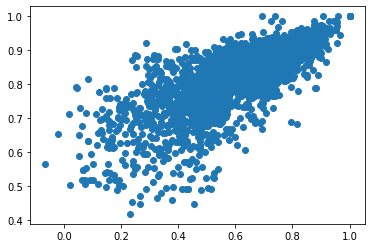

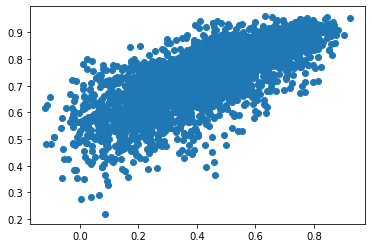

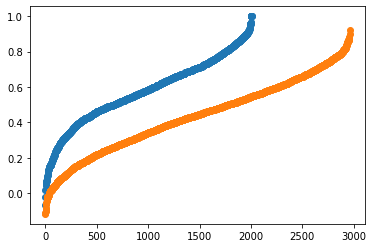

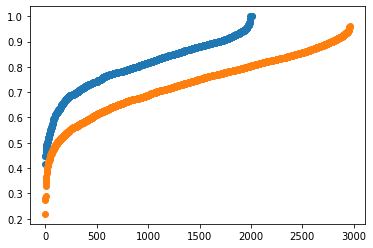

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(correct_label_x, correct_label_y)

plt.show()

plt.scatter(incorrect_label_x, incorrect_label_y)

plt.show()

plt.scatter(list(range(len(correct_label_x))), sorted(correct_label_x))
plt.scatter(list(range(len(incorrect_label_x))), sorted(incorrect_label_x))
plt.show()

plt.scatter(list(range(len(correct_label_y))), sorted(correct_label_y))
plt.scatter(list(range(len(incorrect_label_y))), sorted(incorrect_label_y))
plt.show()


In [ ]:
# Look at some examples of bad predictions
# Correct label contains all the data with ground truth being true
# After sort the similarity score, lower similarity will predict wrong, because it will be below the threshold
temp1, temp2 = zip(*sorted(zip(correct_label_x, correct_label_idx)))
print("True Possitive")
for i in range(len(temp2)-10,len(temp2)):
  print(training_data[temp2[i]])
  print(train_data_ref[temp2[i]])
  print(train_data_response[temp2[i]])
  print(train_data_score[temp2[i]])

print("------------------------------")
print("False Possitive")
for i in range(10):
  print(training_data[temp2[i]])
  print(train_data_ref[temp2[i]])
  print(train_data_response[temp2[i]])
  print(train_data_score[temp2[i]])

True Possitive
{'question': 'Paula wants to test a food to see if it contains acid and/or sugar. When Paula added water and yeast to a sample of the food and put the mixture in a warm water bath, the mixture began to fizz and bubble. What does this chemical reaction indicate?', 'ref': 'The food contains sugar.', 'response': 'The food has sugar in it.', 'score': 'correct', 'aug': False, 'id': 3910}
The food contains sugar.
The food has sugar in it.
correct
{'question': 'Denise made a circuit to light a bulb or run a motor. She used a special switch. Below is the schematic diagram of her circuit. The switch is inside the dotted box. What will happen when she moves the switch to the right?', 'ref': 'The motor will run.', 'response': 'The motor will run.', 'score': 'correct', 'aug': False, 'id': 430}
The motor will run.
The motor will run.
correct
{'question': 'Denise made a circuit to light a bulb or run a motor. She used a special switch. Below is the schematic diagram of her circuit. Th

In [ ]:
# Look at some examples of bad predictions
temp1, temp2 = zip(*sorted(zip(incorrect_label_x, incorrect_label_idx)))
print("False Negative")
for i in range(len(temp2)-10,len(temp2)):
  print(training_data[temp2[i]])
  print(train_data_ref[temp2[i]])
  print(train_data_response[temp2[i]])
  print(train_data_score[temp2[i]])

print("--------------------------------")
print("True Negative")
for i in range(10):
  print(training_data[temp2[i]])
  print(train_data_ref[temp2[i]])
  print(train_data_response[temp2[i]])
  print(train_data_score[temp2[i]])

False Negative
{'question': 'What happens to earth materials during deposition?', 'ref': 'Earth materials settle out during deposition.', 'response': 'During deposition earth materials are moved to a different place.', 'score': 'incorrect', 'aug': False, 'id': 816}
Earth materials settle out during deposition.
During deposition earth materials are moved to a different place.
incorrect
{'question': 'Anne is investigating which objects stick to magnets. She recorded this in her notebook. I was surprised! A nail was stuck to the magnet. When I accidentally touched the nail to a paperclip, the paperclip stuck to the nail. If Anne touched the nail to a brass ring, what do you think would happen and why?', 'ref': 'The brass ring would not stick to the nail because the ring is not iron. The nail is a temporary magnet, but brass cannot become a temporary magnet and thus does not stick to magnets.', 'response': 'It will not stick to the nail because of the brass ring is not made of metal.', 'sc

## Picking threshold
---

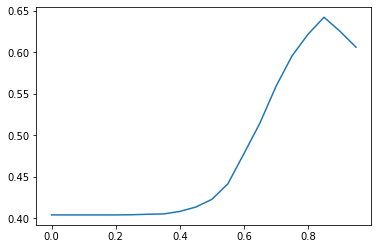

In [ ]:
#Output the pairs with their score
# for i in range(len(test_data_ref)):
#     print("{} \t\t {} \t\t Score: {:.4f}".format(test_data_ref[i], test_data_response[i], cosine_scores[i][i]))
accuracy = []
threshold = []
for i in range(0,100,5):
  threshold_num = i/100;
  result_score = []
  for i in range(len(train_data_ref)):
    if word2vec_sim_score[i] >= threshold_num:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

  correct_predict = 0
  for i in range(len(result_score)):
    if result_score[i] == train_data_score[i]:
      correct_predict += 1

  accuracy.append(correct_predict / len(result_score))
  threshold.append(threshold_num)

plt.plot(threshold, accuracy)

In [ ]:
max_accuracy_idx = accuracy.index(max(accuracy))
print("Threshold = " + str(threshold[max_accuracy_idx]))
print("Validation Accuracy = " + str(accuracy[max_accuracy_idx]))
best_threshold = threshold[max_accuracy_idx]

Threshold = 0.85
Validation Accuracy = 0.6419802777218756


## Testing on Testset
----

In [ ]:
#Compute embedding for both lists
embeddings1 = model.encode(test_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(test_data_response, convert_to_tensor=True)

cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Calculate spacy sim score with word2vec
# https://spacy.io/usage/linguistic-features#vectors-similarity
word2vec_sim_score = []

print(f"Total Number of data points: {len(test_data_ref)}")
print("----------------------------")
for i in range(len(test_data_ref)):
  search_doc = nlp(test_data_ref[i])
  main_doc = nlp(test_data_response[i])

  # remove some of the stop words to generate better score with important words
  search_doc_no_stop_words = nlp(' '.join([str(t) for t in search_doc if not t.is_stop]))
  main_doc_no_stop_words = nlp(' '.join([str(t) for t in main_doc if not t.is_stop]))

  word2vec_sim_score.append(search_doc_no_stop_words.similarity(main_doc_no_stop_words))
  if i%200 == 0:
    print(f"Process: {i} / {len(test_data_ref)}")
  if i==len(test_data_ref)-1:
    print(f"Process finished: {len(test_data_ref)}/{len(test_data_ref)}")

Total Number of data points: 733
----------------------------
Process: 0 / 733
Process: 200 / 733
Process: 400 / 733
Process: 600 / 733
Process finished: 733/733


In [ ]:
result_score = []
for i in range(len(test_data_ref)):
    if cosine_scores[i][i] >= best_threshold:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

correct_predict = 0
for i in range(len(result_score)):
  if result_score[i] == test_data_score[i]:
    correct_predict += 1

print("Testing accuracy:")
print(correct_predict / len(result_score))

Testing accuracy:
0.6139154160982264


## Conclusion

spacy word2vec simlarity performs 0.6139 